## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]
    , l1_ratio=0.0, l2_ratio=0.0
    , drp_ratio=0.2
    , pre_activate=False
):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
        x = Dropout(drp_ratio)(x)
        if pre_activate:
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
        else:
            x = Activation("relu")(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 0.05
EPOCHS = 10
MOMENTUM = 0.95
L1_EXP = [1e-2, 0.0]
L2_EXP = [1e-2, 0.0]
BATCH_SIZE = [32, 128]
PRE_ACTIVATE = [True, False]
Dropout_EXP = [0.1, 0.6]


In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1r, l2r, use_preact, bz, drp_rate in itertools.product(
    L1_EXP, L2_EXP,
    PRE_ACTIVATE, BATCH_SIZE,
    Dropout_EXP
):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    exp_name_tag = "L1%s_L2%s_use_preact%s_batch_size%s_dropout_rate:%s" % (
        str(l1r), str(l2r), str(use_preact), str(bz), str(drp_rate)
    )
    print("%s " % exp_name_tag)
    model = build_mlp(
        input_shape=x_train.shape[1:],
        l1_ratio=l1r, l2_ratio=l2r,
        pre_activate=PRE_ACTIVATE,
        drp_ratio=drp_rate
    )
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bz,
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    results[exp_name_tag] = {
        'train-loss': train_loss,
        'valid-loss': valid_loss,
        'train-acc': train_acc,
        'valid-acc': valid_acc
    }

L10.01_L20.01_use_preactTrue_batch_size32_dropout_rate:0.1 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0   

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 38s 761us/step - loss: 25.6471 - accuracy: 0.1620 - val_loss: 18.5552 - val_accuracy: 0.1127
Epoch 2/10
50000/50000 [==============================] - 37s 734us/step - loss: 14.7073 - accuracy: 0.1519 - val_loss: 16.2669 - val_accuracy: 0.1454
Epoch 3/10
50000/50000 [==============================] - 37s 738us/step - loss: 13.8615 - accuracy: 0.1497 - val_loss: 15.0309 - val_accuracy: 0.1026
Epoch 4/10
50000/50000 [==============================] - 40s 792us/step - loss: 12.5902 - accuracy: 0.1442 - val_loss: 11.5460 - val_accuracy: 0.1117
Epoch 5/10
50000/50000 [==============================] - 37s 735us/step - loss: 12.5230 - accuracy: 0.1449 - val_loss: 10.5857 - val_accuracy: 0.1366
Epoch 6/10
50000/50000 [==============================] - 35s 700us/step - loss: 11.0777 - accuracy: 0.1398 - val_loss: 20.9566 - val_accuracy: 0.1000
Epoch 7/10
50000/50000 [====================

50000/50000 [==============================] - 14s 279us/step - loss: 13.9002 - accuracy: 0.1932 - val_loss: 12.3378 - val_accuracy: 0.1183
Epoch 5/10
50000/50000 [==============================] - 14s 276us/step - loss: 12.6263 - accuracy: 0.1925 - val_loss: 11.5674 - val_accuracy: 0.1074
Epoch 6/10
50000/50000 [==============================] - 14s 276us/step - loss: 11.7043 - accuracy: 0.1890 - val_loss: 11.5329 - val_accuracy: 0.1020
Epoch 7/10
50000/50000 [==============================] - 14s 277us/step - loss: 11.2021 - accuracy: 0.1802 - val_loss: 10.8921 - val_accuracy: 0.1306
Epoch 8/10
50000/50000 [==============================] - 14s 277us/step - loss: 12.3216 - accuracy: 0.1743 - val_loss: 12.8001 - val_accuracy: 0.1409
Epoch 9/10
50000/50000 [==============================] - 14s 284us/step - loss: 11.4626 - accuracy: 0.1595 - val_loss: 15.7516 - val_accuracy: 0.1003
Epoch 10/10
50000/50000 [==============================] - 14s 287us/step - loss: 11.4623 - accuracy: 0.1

50000/50000 [==============================] - 32s 633us/step - loss: 11.3723 - accuracy: 0.1353 - val_loss: 10.6661 - val_accuracy: 0.1163
Epoch 8/10
50000/50000 [==============================] - 32s 638us/step - loss: 10.9856 - accuracy: 0.1227 - val_loss: 10.3172 - val_accuracy: 0.1000
Epoch 9/10
50000/50000 [==============================] - 32s 638us/step - loss: 10.3218 - accuracy: 0.1009 - val_loss: 10.3247 - val_accuracy: 0.1000
Epoch 10/10
50000/50000 [==============================] - 32s 632us/step - loss: 10.3218 - accuracy: 0.0993 - val_loss: 10.3130 - val_accuracy: 0.1000
L10.01_L20.0_use_preactTrue_batch_size32_dropout_rate:0.6 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   


50000/50000 [==============================] - 14s 279us/step - loss: 11.6540 - accuracy: 0.1773 - val_loss: 12.8754 - val_accuracy: 0.1010
L10.01_L20.0_use_preactTrue_batch_size128_dropout_rate:0.6 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 33s 662us/step - loss: 29.6050 - accuracy: 0.1010 - val_loss: 10.3215 - val_accuracy: 0.1000
Epoch 2/10
50000/50000 [==============================] - 32s 644us/step - loss: 10.3177 - accuracy: 0.1000 - val_loss: 10.3354 - val_accuracy: 0.1000
Epoch 3/10
50000/50000 [==============================] - 33s 655us/step - loss: 10.3171 - accuracy: 0.0991 - val_loss: 10.3132 - val_accuracy: 0.1000
Epoch 4/10
50000/50000 [==============================] - 32s 643us/step - loss: 10.3171 - accuracy: 0.0995 - val_loss: 10.3211 - val_accuracy: 0.1000
Epoch 5/10
50000/50000 [==============================] - 33s 670us/step - loss: 10.3170 - accuracy: 0.0996 - val_loss: 10.3172 - val_accuracy: 0.1000
Epoch 6/10
50000/50000 [==============================] - 33s 652us/step - loss: 10.3170 - accuracy: 0.1005 - val_loss: 10.3225 - val_accuracy: 0.1000
Epoch 7/10
50000/50000 [====================

50000/50000 [==============================] - 18s 360us/step - loss: 11.4011 - accuracy: 0.1060 - val_loss: 10.3186 - val_accuracy: 0.1000
Epoch 5/10
50000/50000 [==============================] - 18s 361us/step - loss: 10.3187 - accuracy: 0.1004 - val_loss: 10.3175 - val_accuracy: 0.1000
Epoch 6/10
50000/50000 [==============================] - 18s 361us/step - loss: 10.3182 - accuracy: 0.1001 - val_loss: 10.3169 - val_accuracy: 0.1000
Epoch 7/10
50000/50000 [==============================] - 18s 360us/step - loss: 10.3181 - accuracy: 0.0987 - val_loss: 10.3185 - val_accuracy: 0.1000
Epoch 8/10
50000/50000 [==============================] - 18s 361us/step - loss: 10.3179 - accuracy: 0.1001 - val_loss: 10.3141 - val_accuracy: 0.1000
Epoch 9/10
50000/50000 [==============================] - 18s 362us/step - loss: 10.3179 - accuracy: 0.1001 - val_loss: 10.3128 - val_accuracy: 0.1000
Epoch 10/10
50000/50000 [==============================] - 18s 362us/step - loss: 10.3180 - accuracy: 0.0

Epoch 8/10
50000/50000 [==============================] - 36s 725us/step - loss: 2.3088 - accuracy: 0.1030 - val_loss: 2.3093 - val_accuracy: 0.1000
Epoch 9/10
50000/50000 [==============================] - 36s 722us/step - loss: 2.3090 - accuracy: 0.0995 - val_loss: 2.3075 - val_accuracy: 0.1000
Epoch 10/10
50000/50000 [==============================] - 37s 735us/step - loss: 2.3086 - accuracy: 0.1013 - val_loss: 2.3087 - val_accuracy: 0.1000
L10.0_L20.01_use_preactTrue_batch_size128_dropout_rate:0.1 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_____________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 34s 688us/step - loss: 4.1343 - accuracy: 0.2423 - val_loss: 3.4438 - val_accuracy: 0.1183
Epoch 2/10
50000/50000 [==============================] - 33s 667us/step - loss: 2.6411 - accuracy: 0.2421 - val_loss: 2.8458 - val_accuracy: 0.2061
Epoch 3/10
50000/50000 [==============================] - 33s 668us/step - loss: 2.6951 - accuracy: 0.2347 - val_loss: 2.6610 - val_accuracy: 0.1935
Epoch 4/10
50000/50000 [==============================] - 33s 670us/step - loss: 2.6438 - accuracy: 0.2287 - val_loss: 4.0108 - val_accuracy: 0.1028
Epoch 5/10
50000/50000 [==============================] - 33s 669us/step - loss: 2.5743 - accuracy: 0.2255 - val_loss: 2.6602 - val_accuracy: 0.1156
Epoch 6/10
50000/50000 [==============================] - 34s 672us/step - loss: 2.5171 - accuracy: 0.2231 - val_loss: 2.8052 - val_accuracy: 0.1671
Epoch 7/10
50000/50000 [==============================] 

50000/50000 [==============================] - 16s 313us/step - loss: 2.3036 - accuracy: 0.3427 - val_loss: 2.3371 - val_accuracy: 0.2881
Epoch 5/10
50000/50000 [==============================] - 16s 314us/step - loss: 2.2588 - accuracy: 0.3395 - val_loss: 2.6335 - val_accuracy: 0.1953
Epoch 6/10
50000/50000 [==============================] - 16s 313us/step - loss: 2.2374 - accuracy: 0.3387 - val_loss: 2.9289 - val_accuracy: 0.1485
Epoch 7/10
50000/50000 [==============================] - 16s 313us/step - loss: 2.2488 - accuracy: 0.3366 - val_loss: 2.9238 - val_accuracy: 0.1769
Epoch 8/10
50000/50000 [==============================] - 16s 314us/step - loss: 2.2304 - accuracy: 0.3355 - val_loss: 2.5648 - val_accuracy: 0.2013
Epoch 9/10
50000/50000 [==============================] - 16s 314us/step - loss: 2.1967 - accuracy: 0.3399 - val_loss: 2.3711 - val_accuracy: 0.2602
Epoch 10/10
50000/50000 [==============================] - 16s 313us/step - loss: 2.2201 - accuracy: 0.3365 - val_los

Epoch 8/10
50000/50000 [==============================] - 37s 731us/step - loss: 1.6537 - accuracy: 0.4073 - val_loss: 1.7528 - val_accuracy: 0.3967
Epoch 9/10
50000/50000 [==============================] - 37s 731us/step - loss: 1.6519 - accuracy: 0.4108 - val_loss: 1.7401 - val_accuracy: 0.4230
Epoch 10/10
50000/50000 [==============================] - 37s 730us/step - loss: 1.6290 - accuracy: 0.4177 - val_loss: 1.6394 - val_accuracy: 0.4312
L10.0_L20.0_use_preactTrue_batch_size32_dropout_rate:0.6 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_______________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 16s 320us/step - loss: 2.1792 - accuracy: 0.1929 - val_loss: 2.3516 - val_accuracy: 0.1011
Epoch 2/10
50000/50000 [==============================] - 14s 290us/step - loss: 2.0177 - accuracy: 0.2435 - val_loss: 2.2195 - val_accuracy: 0.1477
Epoch 3/10
50000/50000 [==============================] - 14s 290us/step - loss: 1.9655 - accuracy: 0.2720 - val_loss: 2.2360 - val_accuracy: 0.1433
Epoch 4/10
50000/50000 [==============================] - 14s 290us/step - loss: 1.9469 - accuracy: 0.2828 - val_loss: 2.2799 - val_accuracy: 0.1270
Epoch 5/10
50000/50000 [==============================] - 15s 290us/step - loss: 1.9361 - accuracy: 0.2874 - val_loss: 2.2086 - val_accuracy: 0.1554
Epoch 6/10
50000/50000 [==============================] - 15s 308us/step - loss: 1.9235 - accuracy: 0.2933 - val_loss: 2.2101 - val_accuracy: 0.1724
Epoch 7/10
50000/50000 [==============================] 

50000/50000 [==============================] - 33s 665us/step - loss: 2.1705 - accuracy: 0.1688 - val_loss: 2.7821 - val_accuracy: 0.1424
Epoch 5/10
50000/50000 [==============================] - 33s 665us/step - loss: 2.1875 - accuracy: 0.1599 - val_loss: 2.7330 - val_accuracy: 0.1006
Epoch 6/10
50000/50000 [==============================] - 33s 666us/step - loss: 2.1879 - accuracy: 0.1573 - val_loss: 2.9026 - val_accuracy: 0.1175
Epoch 7/10
50000/50000 [==============================] - 33s 666us/step - loss: 2.1839 - accuracy: 0.1598 - val_loss: 2.3325 - val_accuracy: 0.1103
Epoch 8/10
50000/50000 [==============================] - 33s 665us/step - loss: 2.1922 - accuracy: 0.1555 - val_loss: 2.3941 - val_accuracy: 0.1109
Epoch 9/10
50000/50000 [==============================] - 33s 666us/step - loss: 2.1930 - accuracy: 0.1520 - val_loss: 2.4064 - val_accuracy: 0.1005
Epoch 10/10
50000/50000 [==============================] - 33s 665us/step - loss: 2.1833 - accuracy: 0.1516 - val_los

Epoch 8/10
50000/50000 [==============================] - 14s 280us/step - loss: 1.9035 - accuracy: 0.3053 - val_loss: 2.2440 - val_accuracy: 0.1572
Epoch 9/10
50000/50000 [==============================] - 14s 280us/step - loss: 1.9025 - accuracy: 0.3059 - val_loss: 2.2781 - val_accuracy: 0.1483
Epoch 10/10
50000/50000 [==============================] - 14s 281us/step - loss: 1.8954 - accuracy: 0.3113 - val_loss: 2.1924 - val_accuracy: 0.2024


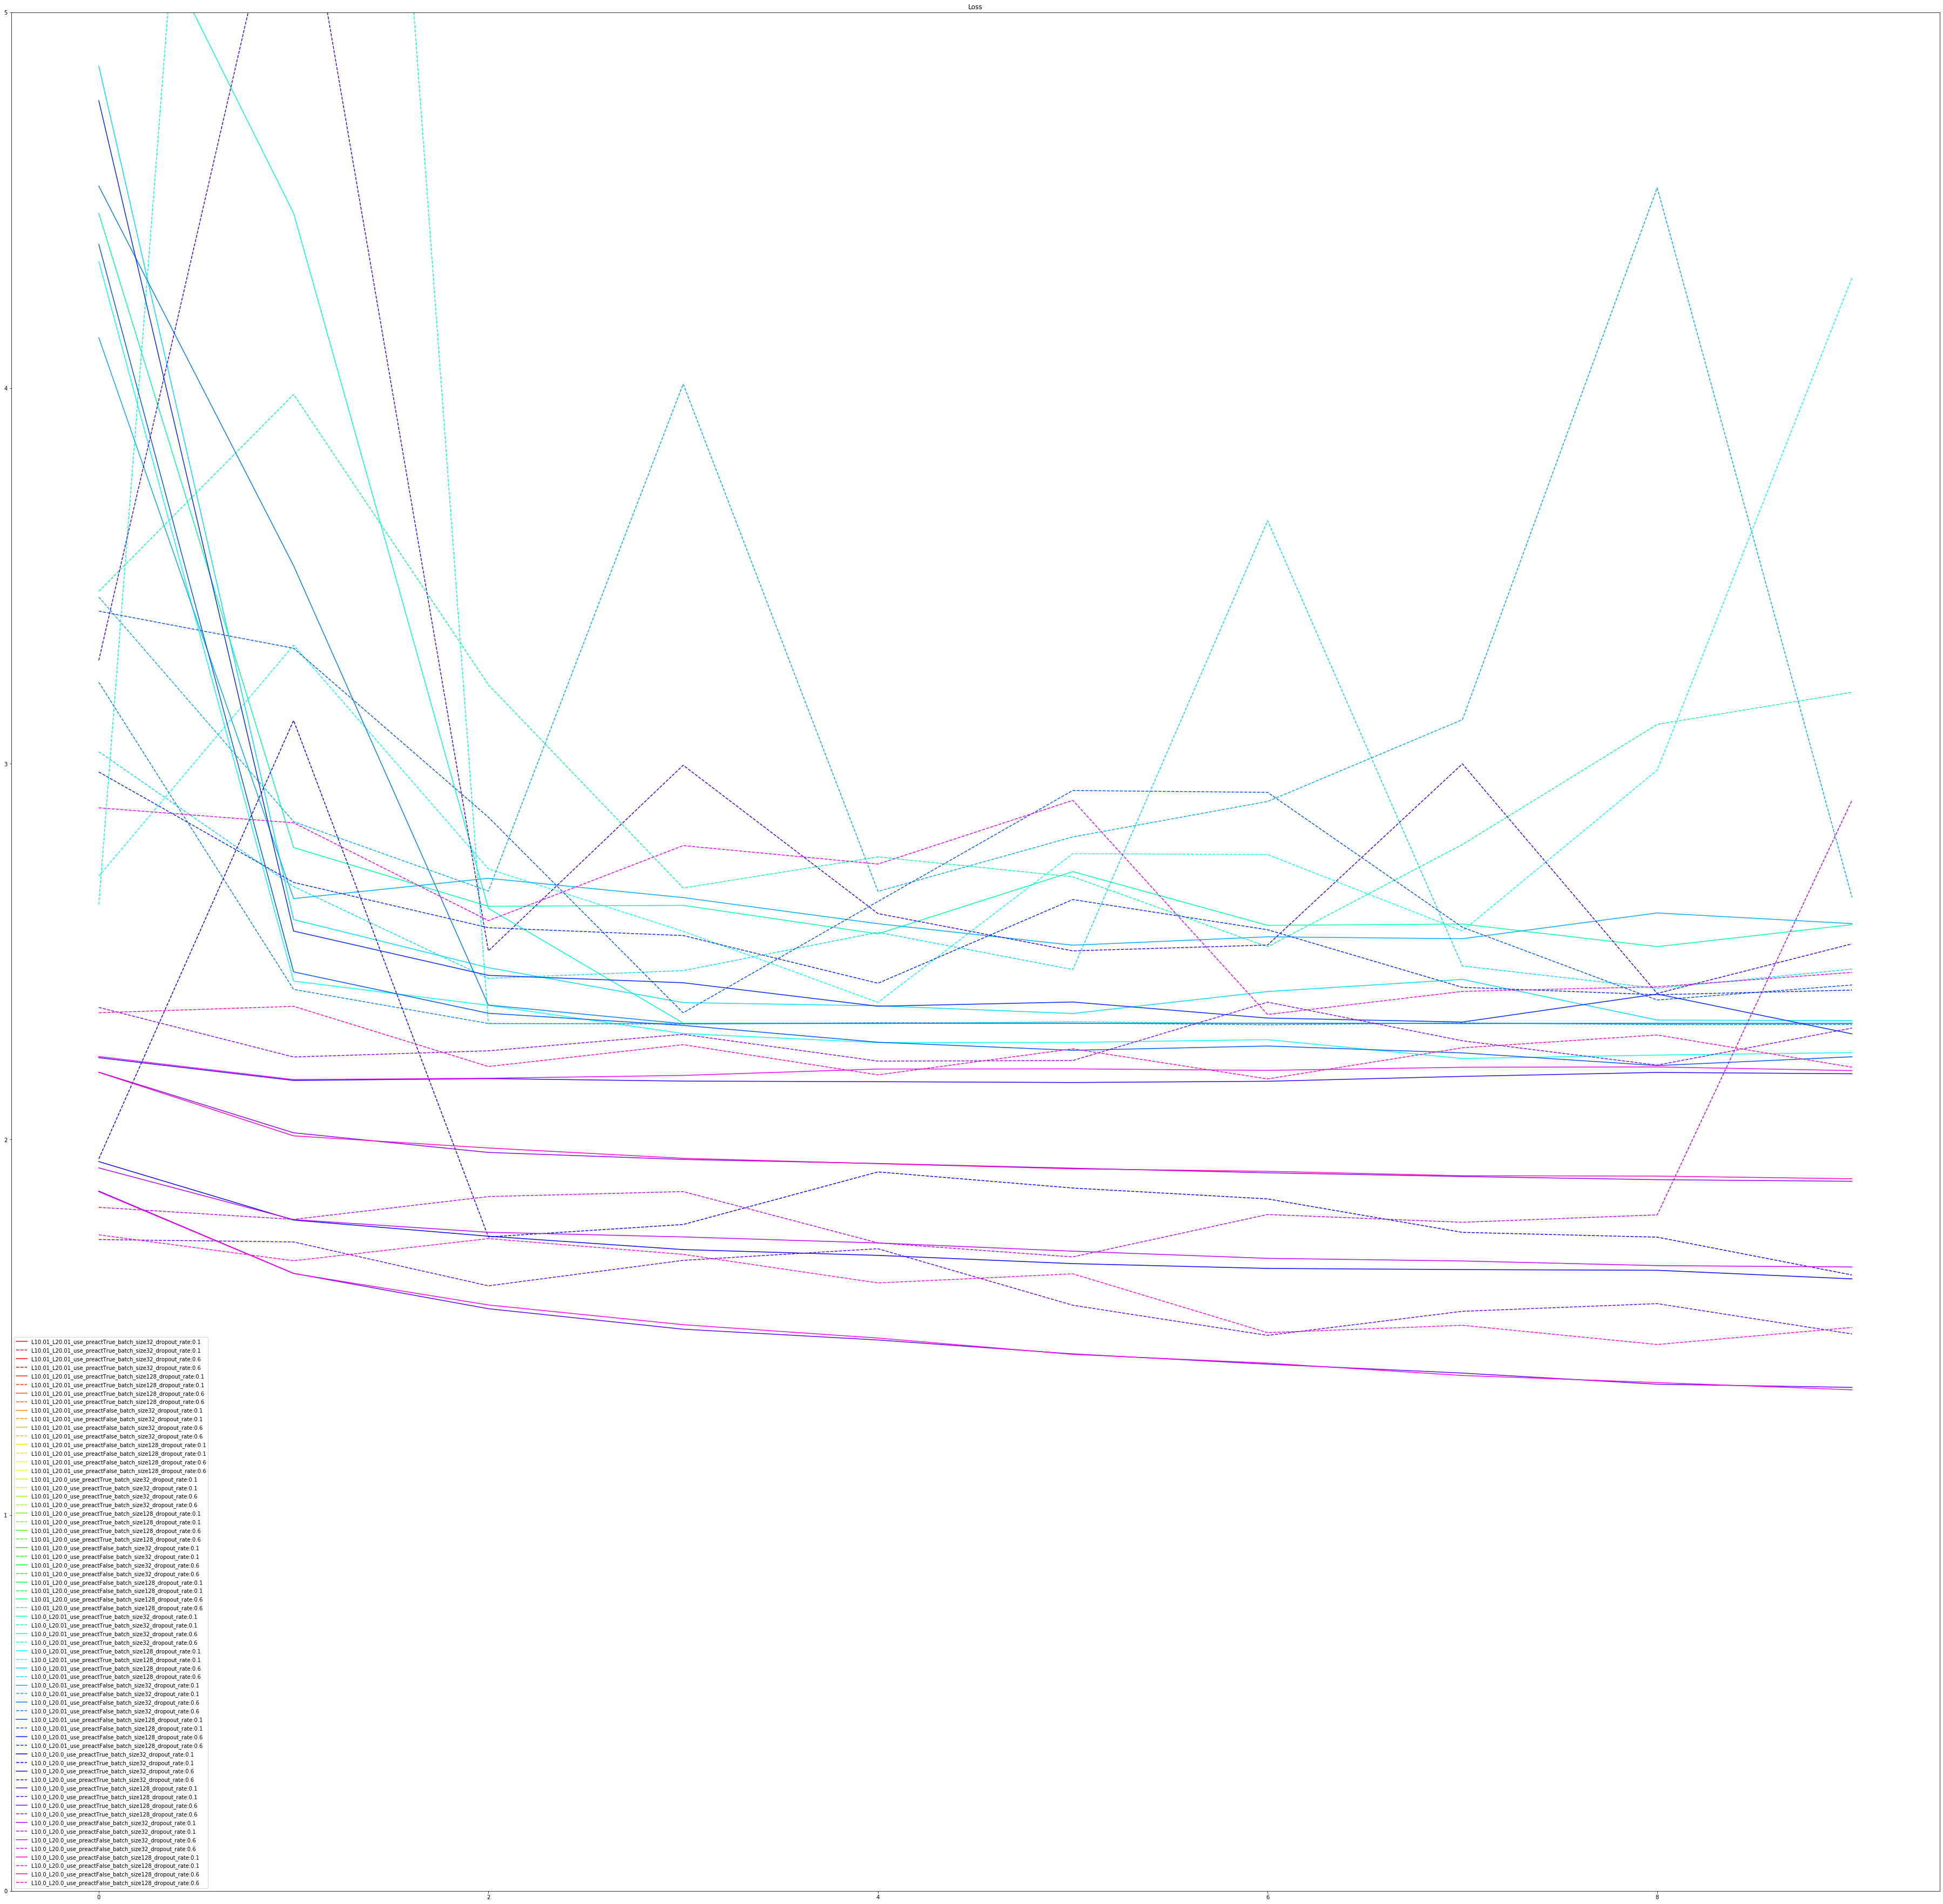

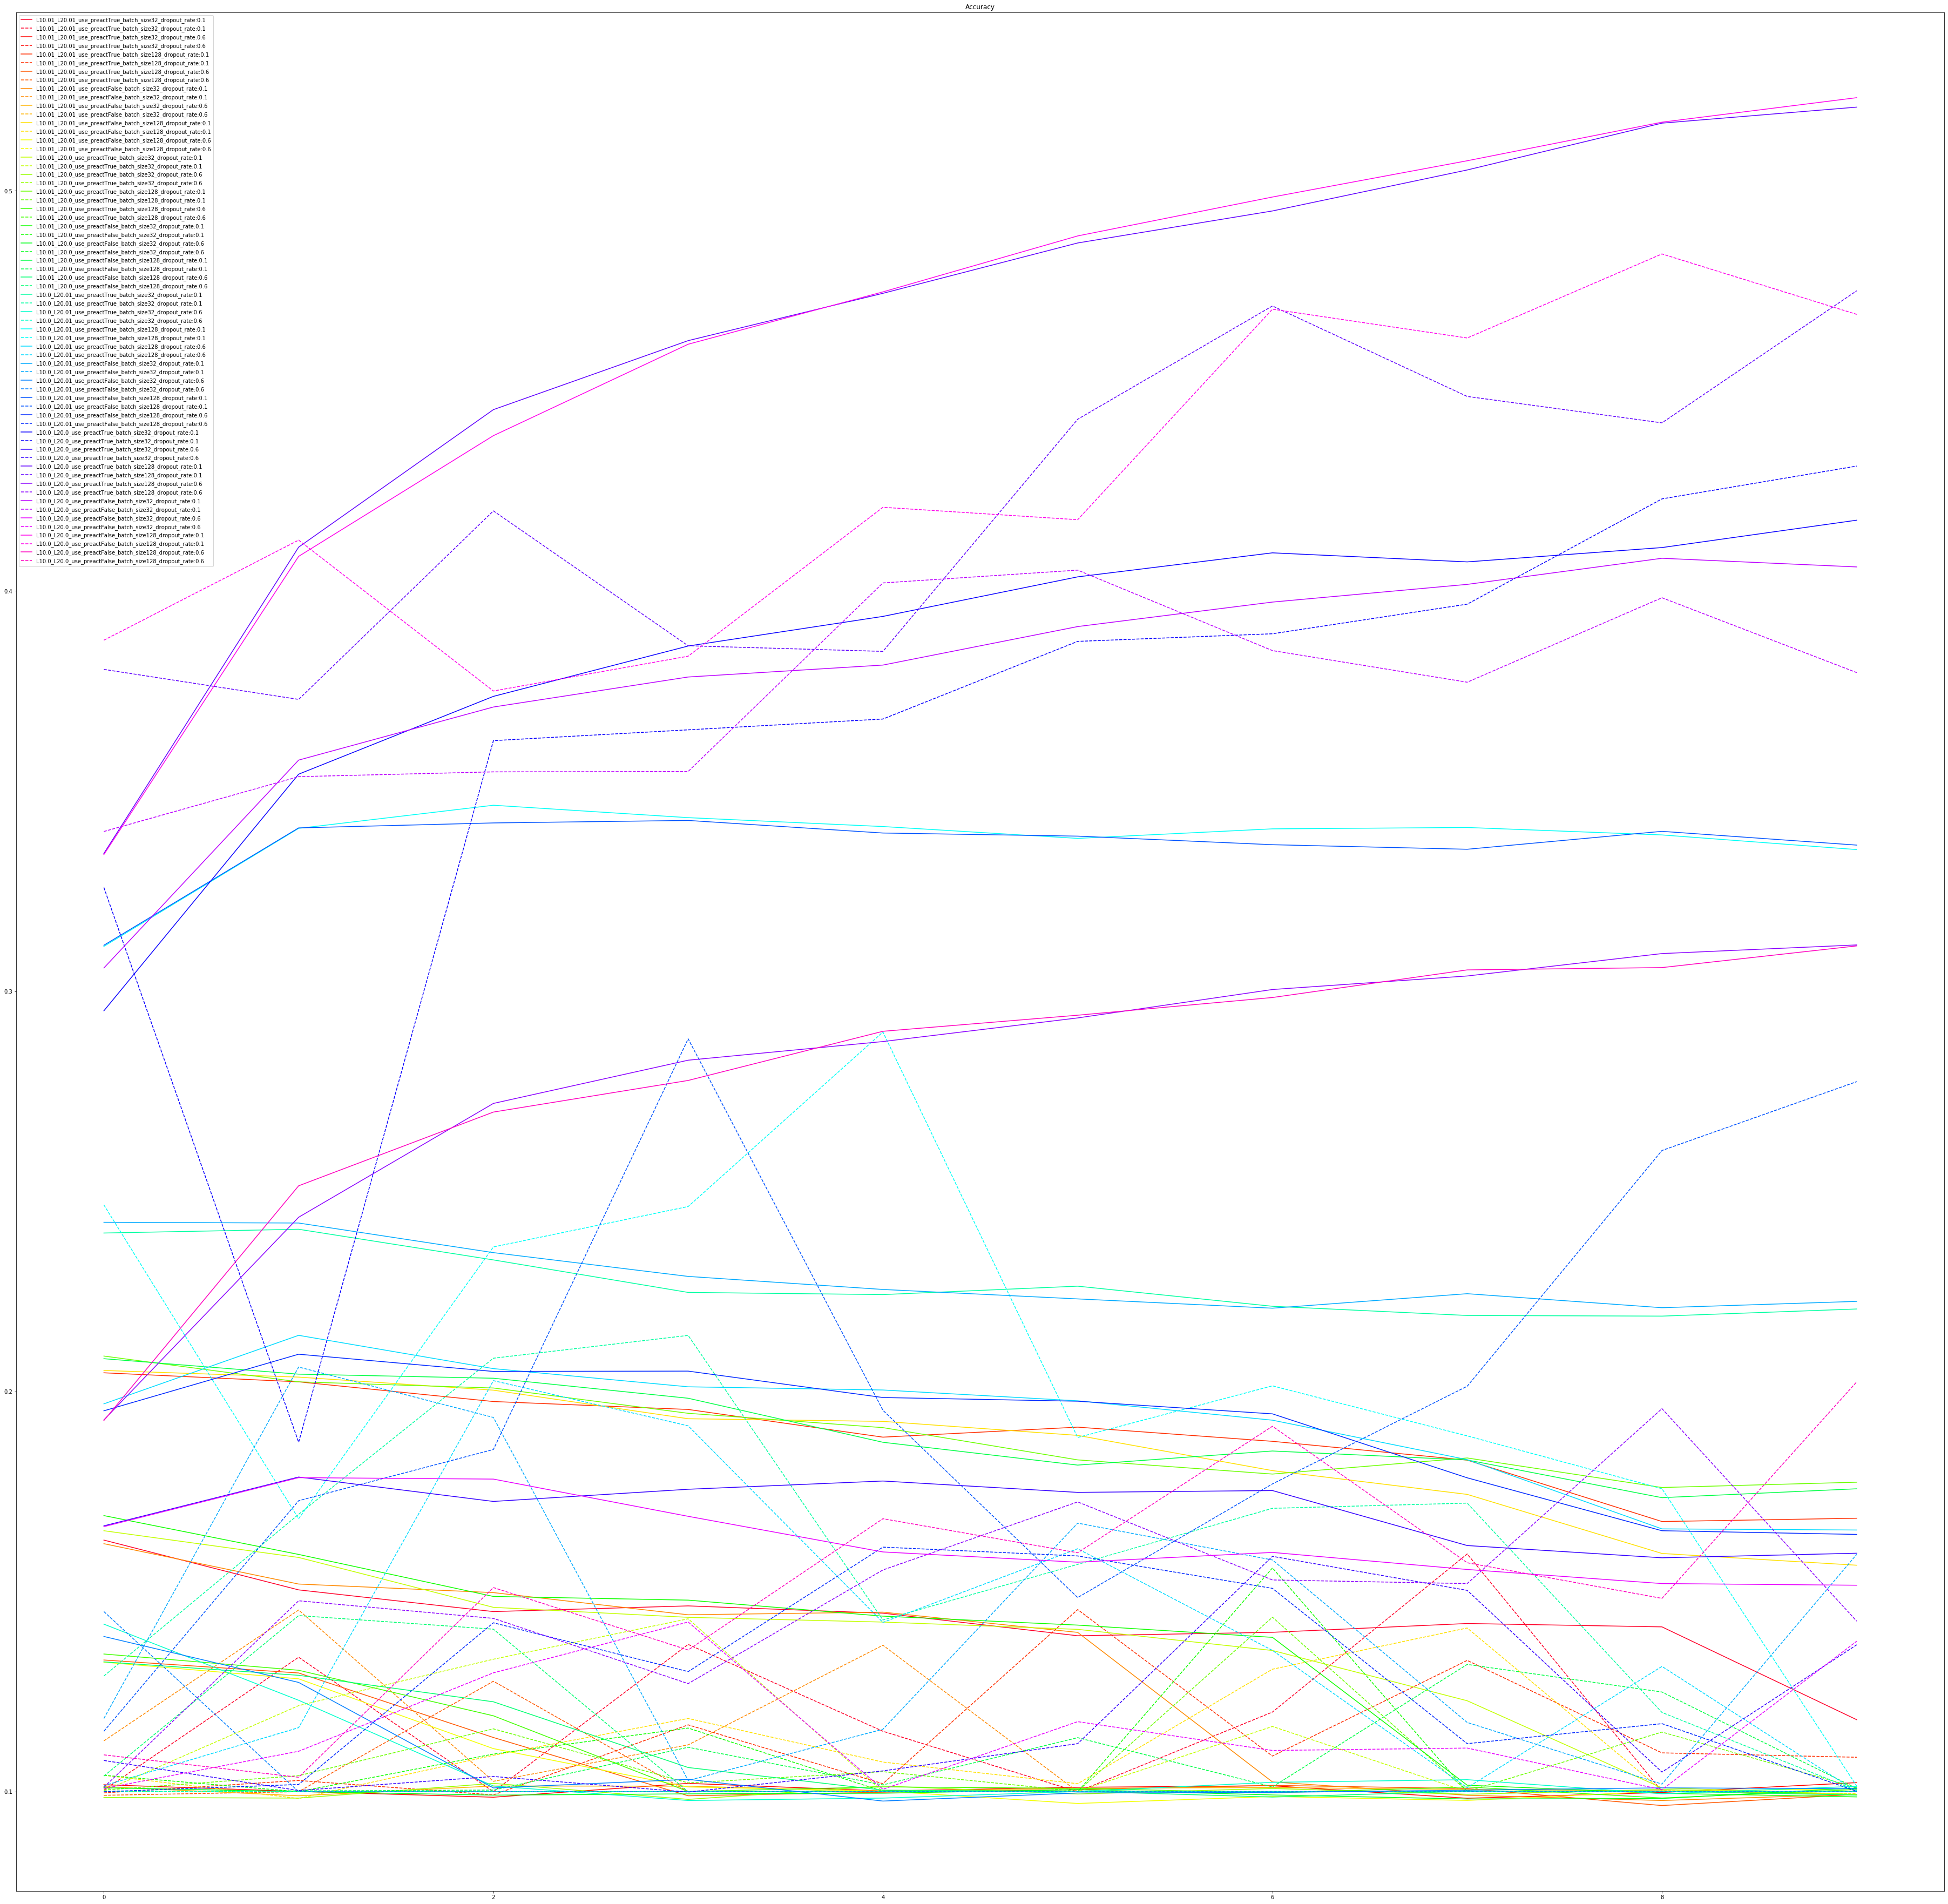

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(64,64))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(64,64))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()